<a href="https://colab.research.google.com/github/rafabenevente/AM_1/blob/main/AM_1_Titanic_Predi%C3%A7%C3%A3o_dos_sobreviventes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [403]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


Titanic: Predição dos Sobreviventes com Machine Learning
===

# Conhecendo o Conjunto de Dados


**Dicionário**

|Variável |Definição|Chave|
|:---- |----|----:|
|survival  | Sobrevivente |0 = Não, 1 = Sim|
|pclass |Classe da ticket| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex  |Sexo| 	
|Age  | Idade em anos| 	
|sibsp| # de irmãs / cônjuges a bordo do Titanic |
|parch |# de pais / crianças a bordo do Titanic |	
|ticket| ID do ticket| 	
|fare 	|Tarifa de passageiro (libra esterlina)| 	
|cabin 	|número da cabine| 	
|embarked |Porto de embarcação|C = Cherbourg, Q = Queenstown, S = Southampton|


**Observações**
- pclass: Status socieconômico
    - 1st = Alta
    - 2nd = Média
    - 3rd = Baixa
- age: A idade é fracionária se menor que 1. Se a idade for estimada, é na forma de xx.5

- sibsp: O conjunto de dados define as relações familiares desta forma ...
    - Sibling = irmão, irmã, meio-irmão, meia-irmã
    - Spouse = marido, esposa (amantes e noivos foram ignorados)

- parch: O conjunto de dados define as relações familiares desta forma ...
    - Parent = mãe, pai
    - Child = filha, filho, enteada, enteado
    - Algumas crianças viajavam apenas com a babá, portanto parch = 0 para elas.



## Importação e características

In [404]:
test_url = 'https://raw.githubusercontent.com/rafabenevente/AM_1/main/test.csv'
train_url = 'https://raw.githubusercontent.com/rafabenevente/AM_1/main/train.csv'
validation_url = 'https://raw.githubusercontent.com/galvaowesley/MachineLearning_Learning/master/Titanic%20-%20Suvivors%20Classification/gender_submission.csv'

# Importa as bibliotecas de cálculo e manipulação de dados
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sns


In [405]:
# Fonte: https://stackoverflow.com/questions/63745343/annotate-percentage-of-group-within-a-seaborn-countplot
def barPlotPercent(df, atributo1, atributo2):
  '''
  Função que recebe um dataframe e dois atributos categóricos, realiza o agrupamento 
  de ambos e mostra a contagem e percentual do atributo1 em função do atributo2. 
  '''

  # prepare the dataset
  df = (df
        .groupby([atributo1, atributo2])
        .size()
        .reset_index()
        #.replace({"Survived": {0:"no", 1:"yes"}})
        .rename(columns={0:"count"}))

  # Calcula o percentual do atributo2 % por níveis do atributo1.
  df["percent"] = (df
                  .groupby(atributo1)
                  .apply(lambda x: x["count"] / x["count"].sum()).values)

  # sort the dataframe to match the drawing order
  df.sort_values(by=[atributo2, atributo1], inplace=True)

  # Visualização
  plt.style.use('ggplot')
  fig = sns.catplot(
    x="count", y=atributo1, hue=atributo2,
    kind="bar", data=df, height=4, aspect=2)

  for i, bar in enumerate(fig.ax.patches):
    
      height = bar.get_height()
      fig.ax.annotate(
          # reference the pre-calculated row in the dataframe
          f"{df.iloc[i, 3] :.0%}",
          xycoords="data",
          xytext=(20, -15),
          textcoords="offset points",
          xy=(bar.get_width(), bar.get_y()),
          ha='center', va='center')

  # make space for annonations
  plt.margins(x=0.2)
  plt.show()

In [406]:
# Carregamento daa base de dados inicialmente separada em treino e teste
train = pd.read_csv(train_url)
test =  pd.read_csv(test_url)

In [407]:
# Dimensão da base de dados
print("Treino tem {} linhas e {} colunas \n". format(train.shape[0], train.shape[1]))
print("Teste tem {} linhas e {} colunas \n". format(test.shape[0], test.shape[1]))

Treino tem 891 linhas e 12 colunas 

Teste tem 418 linhas e 11 colunas 



Há, portanto, 1309 linhas ao total. O conjunto de dados original sofreu split na proporção: 68% para treino e 32% para teste. 

In [408]:
# Aparência do train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [409]:
# Tipo de dados das variáveis
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Engenharia de atributos



## Junção dos datasets de treino e teste

In [410]:
print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

# salvar os índices dos datasets para recuperação posterior
train_idx = train.shape[0]
test_idx = test.shape[0]

# concatenar treino e teste em um único DataFrame
all_data = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

print(f"All_data shape {all_data.shape}")

Train shape (891, 12)
Test shape (418, 11)
All_data shape (1309, 12)


## Imputação de dados ausentes

In [411]:
# Contagem de dados faltantes por atributo
all_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

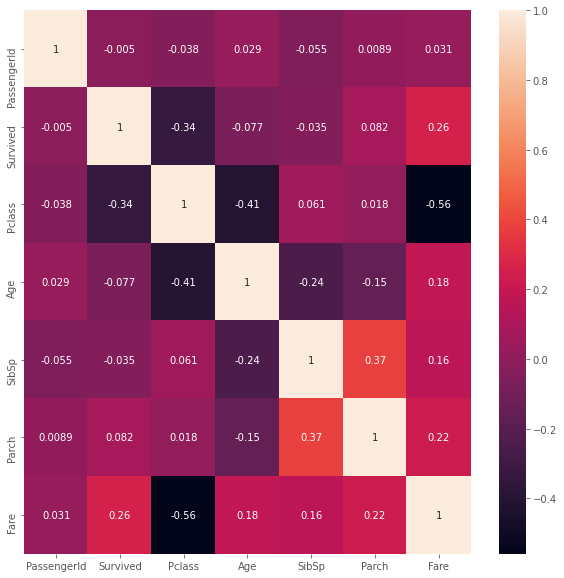

In [412]:
# Heatmap de coeficiente de correlação entre as variáveis
plt.figure(figsize=(10,10))
sns.heatmap(all_data.corr(), annot = True)

### Age

A abordagem de imputação de dados para `Age` e `Fare` é baseada no preenchimento dos campos faltantes com medidas de tendência central. Para tanto, verificou-se a o formato da distribuição a fim de se escolher a melhor medida. 

https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#1.-Exploratory-Data-Analysis

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


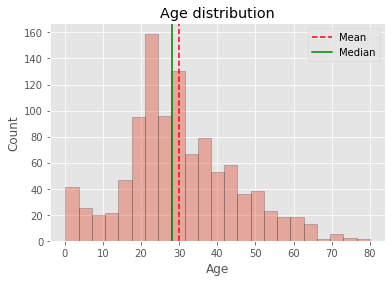

In [413]:

# Cálculo da média e mediana
mean = all_data['Age'].mean()
median =all_data['Age'].median()

plt.title("Age distribution")
sns.distplot(a=all_data['Age'], kde = False,
             hist_kws = {'edgecolor':'black'})
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')

plt.ylabel("Count")
plt.legend({'Mean':mean,'Median':median})
plt.show()


A distribuição aparenta estar positivamente enviesada para direita, portanto, ao invés do uso da média um substituto para dados faltantes, utilizou-se a mediana. 

In [414]:
# Mediana da idade agrupada por PClas
age_pclass = all_data.groupby(['Pclass']).median()['Age']
age_pclass

Pclass
1    39.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [415]:
# Preenche os NA's com a mediana da idade por classe social
all_data['Age'] = all_data.groupby(['Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Fare

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


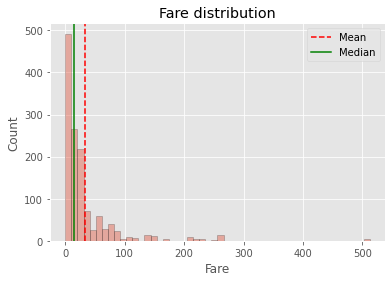

In [416]:

# Cálculo da média e mediana
mean = all_data['Fare'].mean()
median =all_data['Fare'].median()

plt.title("Fare distribution")
sns.distplot(a=all_data['Fare'], kde = False, hist_kws = {'edgecolor':'black'})
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')

plt.ylabel("Count")
plt.legend({'Mean':mean,'Median':median})
plt.show()


Semelhantemente ao atributo `Age`, a distribuição de `Fare` aparenta estar positivamente enviesada para direita, portanto, utilizou-se a mediana como substituto para dados faltantes. 

In [417]:
# Fill NA's with Fare median
fare_median = all_data['Fare'].median()
all_data['Fare'].fillna(fare_median, inplace=True)


### Cabin

In [418]:
# Lista os nomes únicos das cabines
all_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [419]:
# Preenche os NA's com a letra U de Unknown
all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')

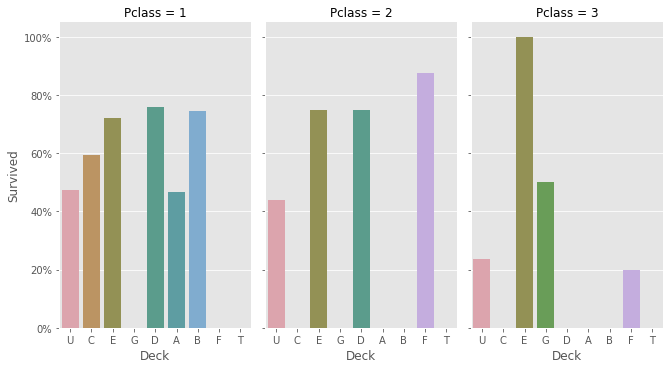

In [420]:
g = sns.catplot(x="Deck", y="Survived", col="Pclass",
                 data=all_data[:train_idx], saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

In [421]:
idx = all_data[all_data['Deck'] == 'T'].index
all_data.loc[idx, 'Deck'] = 'A'

all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')
all_data['Deck'].value_counts()

U      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

### Embarked

Para o atributo `Embarked`, verificou-se as linhas que estavam com os dados faltantes. Uma vez que há apenas duas ocorrências, dada a classe social `Pclass == 1` para ambos, os dados foram imputados com identificação do porto onde há maior ocorrência dessa classe social, ou seja, do porto Cherbourg(C). 

In [422]:
all_data.query('Embarked != "S" & Embarked != "C" & Embarked != "Q"')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,ABC
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,ABC


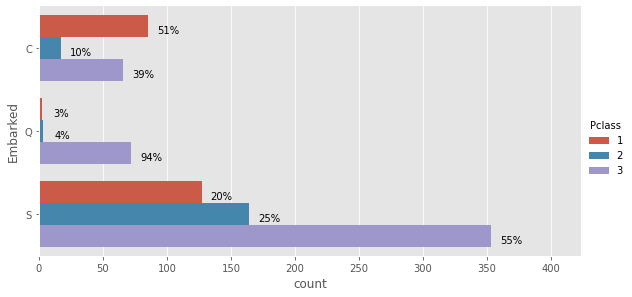

In [423]:
# Visualização de Classe Social por Porto de Embarcação
barPlotPercent(train, 'Embarked', 'Pclass')

In [424]:
# embarked
embarked_top = all_data['Embarked'].value_counts()[0]
all_data['Embarked'].fillna('C', inplace=True)

## Novos atributos

### AgeGroup

https://www.encyclopedia-titanica.org/community/threads/age-of-majority.4620/

In [425]:
# Cria o atributo AgeGroup que categoriza o passageiro de acordo com a sua idade
all_data['AgeGroup']  = ''
for row in all_data.index:
  if all_data['Age'][row] < 12.0:
    all_data['AgeGroup'][row]  = 'Child'
  if all_data['Age'][row] >= 12.0 and all_data['Age'][row] < 21.0:
    all_data['AgeGroup'][row]  = 'Teenager'
  if all_data['Age'][row] >= 21.0 and all_data['Age'][row] < 50.0:
    all_data['AgeGroup'][row]  = 'Adult'
  if all_data['Age'][row] >= 50.0:
    all_data['AgeGroup'][row]  = 'Old'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python

### Title

https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

https://www.kaggle.com/startupsci/titanic-data-science-solutions




In [426]:
# Extrai os títulos dos nomes e armazena num atributo próprio
all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.')
# Lista os atributos por Sexo
pd.crosstab(all_data['Title'], all_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

In [427]:
# Substituição dos sortidos títulos por Mr, Mrs, Miss e Master
def replace_titles(x):
    title=x['Title']
    if title in ['Sir', 'Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
all_data['Title']=all_data.apply(replace_titles, axis=1)

In [428]:
all_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

### FamilySize

O tamanho da família é definido pela soma dos atributos `SibSp` e`Parch` mais 1. Este último corresponde ao indivíduo, que pode estar viajando sozinho. 

In [429]:
# Cria o atributo que corresponde ao tamanho da família à bordo
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

# Alone

Criou-se a variável categórica `Alone` que indica se o passageiro está viajando sozinho ou não, baseada no tamanho da família. 1 para viajando sozinho, e 0 caso contrário. 

In [430]:
all_data['Alone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'Alone'] = 1
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,AgeGroup,Title,FamilySize,Alone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,U,Adult,Mr,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,ABC,Adult,Mrs,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U,Adult,Miss,1,1


# Análise Exploratória dos Dados

Função para automatizar o agrupamento de duas variáveis categóricas e gera uma visualização do relacionamento de ambas com contagem e percentual. 

## Sobreviventes

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Survived')

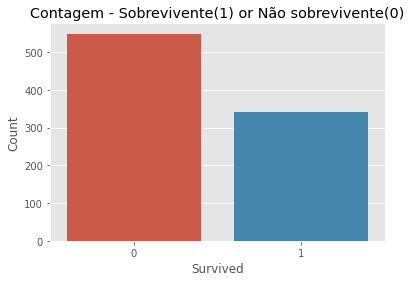

In [431]:
# Contagem de sobreviventes e não sobreviventes
plt.title("Contagem - Sobrevivente(1) or Não sobrevivente(0)")
sns.countplot(train.Survived)
plt.ylabel("Count")
plt.xlabel("Survived")

## Gênero

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Survived')

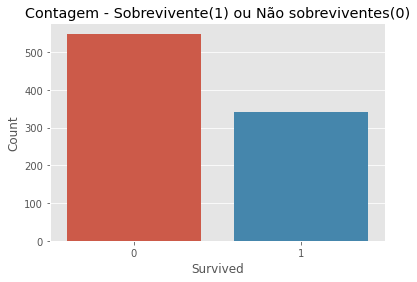

In [432]:
# Contagem de sobreviventes e não sobreviventes
plt.title("Contagem - Sobrevivente(1) ou Não sobreviventes(0)")
sns.countplot(train.Survived)
plt.ylabel("Count")
plt.xlabel("Survived")

In [433]:
# Sumarização de Survived por gênero
train.groupby(['Survived', 'Sex'])['Sex'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64

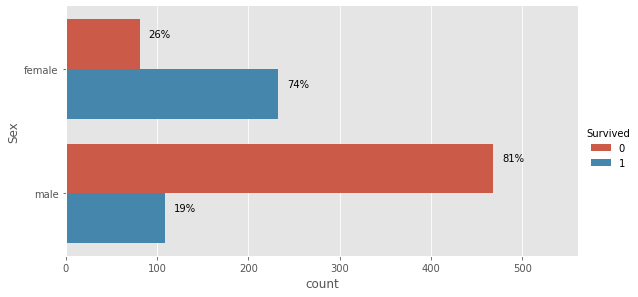

In [434]:
# Visualização de Survived por gênero
barPlotPercent(train, 'Sex', 'Survived')

## Classe Social (Pclass)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Pclass')

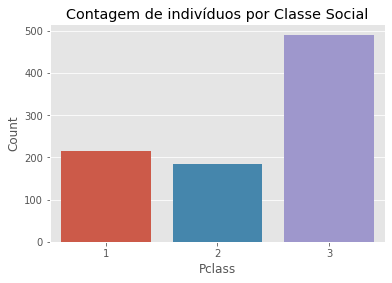

In [435]:
# Contagem de passageiros por Classe Social
plt.title("Contagem de indivíduos por Classe Social")
sns.countplot(train.Pclass)
plt.ylabel("Count")
plt.xlabel("Pclass")

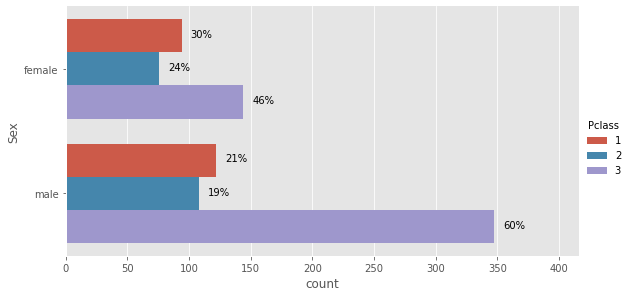

In [436]:
# Percentual e contagem de indivíduos por Classe Social e sexo
barPlotPercent(train, 'Sex', 'Pclass')

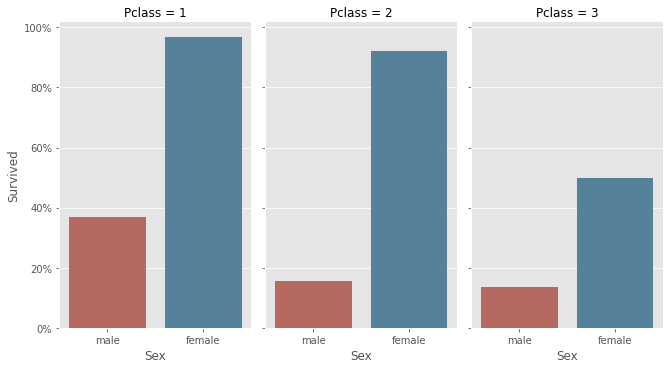

In [437]:
# Percentual de sobreviventes por sexo e classe social
#Fonte: https://stackoverflow.com/questions/52512790/python-seaborn-catplot-how-do-i-change-the-y-axis-scale-to-percentage
g = sns.catplot(x="Sex", y="Survived", col="Pclass",
                 data=train, saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

## Idade

In [438]:
# Sumário de idade
train.Age.describe()


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

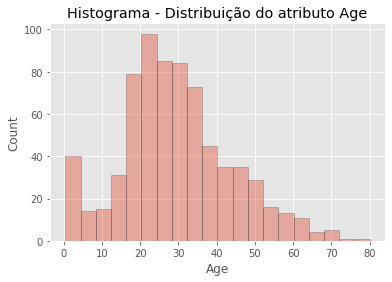

In [439]:
plt.title("Histograma - Distribuição do atributo Age")
sns.distplot(a=train['Age'], kde = False, hist_kws = {'edgecolor':'black'})
plt.ylabel("Count")

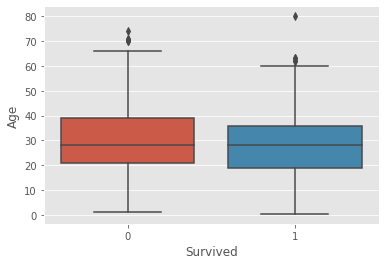

In [440]:
#Boxplot Survived x Age
sns.boxplot(x='Survived', y='Age', data=train)
plt.show()

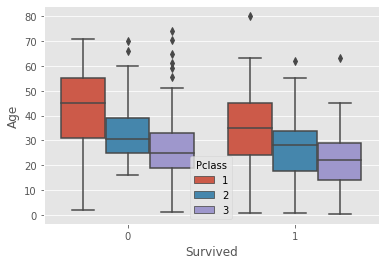

In [441]:
#Boxplot Survived x Age agrupados pela Pclass
sns.boxplot(x='Survived', y='Age', data=train, hue='Pclass')

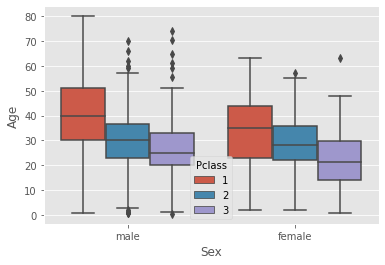

In [442]:
#Boxplot Sex x Age agrupados pela Pclass

sns.boxplot(x='Sex', y='Age', data=train, hue='Pclass')

# Modelos de predição

## Pré-processamento

### Padronização

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [443]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

all_data[['Fare','Age']] = minmax.fit_transform(all_data[['Fare','Age']] )

### Remoção de colunas e preparação de variáveis

In [444]:
# Remoção de colunas que não serão usadas
all_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Preparação de variaveis
all_data['Sex'] = all_data['Sex'].map({'male': 0, 'female': 1}).astype(int)
all_data['Embarked'] = all_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
all_data['AgeGroup'] = all_data['AgeGroup'].map( {'Child': 0, 'Teenager': 1, 'Adult': 2, 'Old':3} ).astype(int)
all_data['Title'] = all_data['Title'].map( {'Mr':0, 'Mrs':1, 'Miss':2, 'Master':3} ).astype(int)
all_data['Deck'] = all_data['Deck'].map( {'ABC':0, 'DE':1, 'FG':2, 'U': 3} ).astype(int)


In [445]:
all_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,AgeGroup,Title,FamilySize,Alone
0,0.0,3,0,0.273456,1,0,0.014151,0,3,2,0,2,0
1,1.0,1,1,0.473882,1,0,0.139136,1,0,2,1,2,0
2,1.0,3,1,0.323563,0,0,0.015469,0,3,2,2,1,1
3,1.0,1,1,0.436302,1,0,0.103644,0,0,2,1,2,0
4,0.0,3,0,0.436302,0,0,0.015713,0,3,2,0,1,1


### Correlação entre variáveis

Explorando o nível de correlação entre as variáveis.

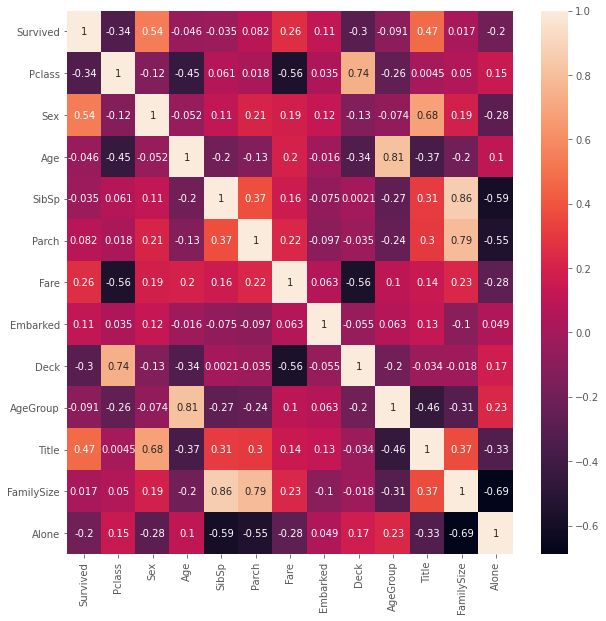

In [446]:
# Heatmap de coeficiente de correlação entre as variáveis
plt.figure(figsize=(10,10))
sns.heatmap(all_data.corr(), annot = True)

In [447]:
# Criação de dummies para atributos categóricos

embarked_dummies = pd.get_dummies(all_data['Embarked'], prefix='Embarked')
all_data = pd.concat([all_data, embarked_dummies], axis=1)
all_data.drop('Embarked', axis=1, inplace=True)

AgeGroup_dummies = pd.get_dummies(all_data['AgeGroup'], prefix='AgeGroup')
all_data = pd.concat([all_data, AgeGroup_dummies], axis=1)
all_data.drop('AgeGroup', axis=1, inplace=True)

Title_dummies = pd.get_dummies(all_data['Title'], prefix='Title')
all_data = pd.concat([all_data,Title_dummies], axis=1)
all_data.drop('Title', axis=1, inplace=True)

Deck_dummies = pd.get_dummies(all_data['Deck'], prefix='Deck')
all_data = pd.concat([all_data,Deck_dummies], axis=1)
all_data.drop('Deck', axis=1, inplace=True)



### Separação dos datasets

In [448]:
# salvar PassengerId para submissao ao Kaggle
passengerId = test['PassengerId']

# carregamento do dataset de validação disponibilizado pelo Kaggle
validation  = pd.read_csv(validation_url)

# Extração do atributo classe Survived
Y_train = train.Survived.copy() 
# Cópia do df tratado até o índice correpondente ao treino
X_train = all_data.iloc[:train_idx]
# Remoção do atributo Survived
X_train.drop(['Survived'], axis=1, inplace=True) 

# Cópia do df tratado até o índice correpondente ao teste
X_test = all_data.iloc[train_idx:]
# Remoção do atributo Survived
X_test.drop(['Survived'], axis=1, inplace=True) 

print(X_train.shape), print(X_test.shape)

(891, 23)
(418, 23)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(None, None)

In [449]:
from sklearn.model_selection import train_test_split
# Separação treino e teste
tr_x, te_x, tr_y, te_y = train_test_split(X_train, Y_train,
                                            test_size = 0.3,
                                            random_state=42,
                                            stratify = Y_train)

##  Arvore de decisão

In [450]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}
dtc = DecisionTreeClassifier()
gs = GridSearchCV(dtc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                

### Predição e avaliação do modelo

In [451]:
# Melhores parametros apontados pelo grid search
dtc = gs.best_estimator_

dtc.fit(tr_x, tr_y)
y_pred = dtc.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.8283582089552238


[[142  23]
 [ 23  80]]


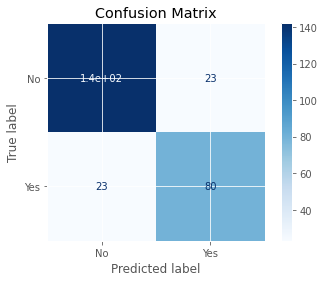

In [452]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(dtc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## K-Neighbors Classifier

In [453]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(1,15,2),
              'metric': ['euclidean', 'manhattan']}

knc = KNeighborsClassifier()
gs = GridSearchCV(knc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 15, 2),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [454]:
# Melhores parametros apontados pelo grid search
knc = gs.best_estimator_

knc.fit(tr_x, tr_y)
y_pred = knc.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.7947761194029851


[[139  26]
 [ 29  74]]


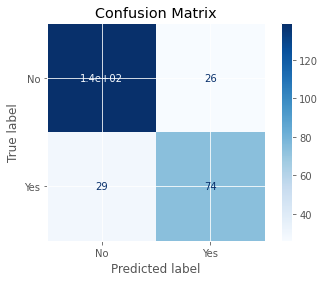

In [455]:
disp = plot_confusion_matrix(knc, te_x, te_y,
                                display_labels=["No", "Yes"],
                                cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## SVM

In [456]:
from sklearn.svm import NuSVC
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'decision_function_shape' : ['ovo', 'ovr']}

svc = NuSVC()
gs = GridSearchCV(svc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [457]:
# Melhores parametros apontados pelo grid search
svc = gs.best_estimator_

svc.fit(tr_x, tr_y)
y_pred = svc.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.8208955223880597


[[145  20]
 [ 28  75]]


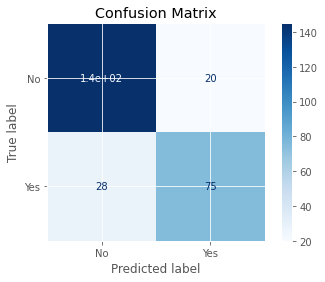

In [458]:
disp = plot_confusion_matrix(svc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Naive Bayes

In [459]:
from sklearn.naive_bayes import MultinomialNB
param_grid = {'alpha': np.linspace(0.1,2,5),
              'fit_prior': [False,True]}

mnb = MultinomialNB()
gs = GridSearchCV(mnb, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.1  , 0.575, 1.05 , 1.525, 2.   ]),
                         'fit_prior': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [460]:
# Melhores parametros apontados pelo grid search
mnb = gs.best_estimator_

mnb.fit(tr_x, tr_y)
y_pred = mnb.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.7761194029850746


[[125  40]
 [ 20  83]]


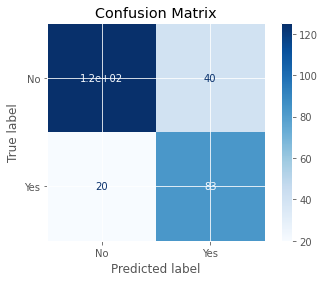

In [461]:
disp = plot_confusion_matrix(mnb, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Logistic regression

In [462]:
from sklearn.linear_model import LogisticRegression
param_grid = {'penalty' : ['l2'],
              'fit_intercept': [False,True],
              'solver' : ['newton-cg', 'liblinear']}

lr = LogisticRegression()
gs = GridSearchCV(lr, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [False, True], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [463]:
# Melhores parametros apontados pelo grid search
lr = gs.best_estimator_

lr.fit(tr_x, tr_y)
y_pred = lr.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.832089552238806


[[143  22]
 [ 23  80]]


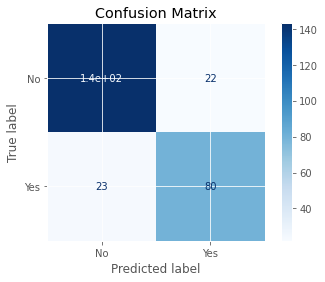

In [464]:
disp = plot_confusion_matrix(lr, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Validação Final

In [465]:
# Decision Tree
final_predDTC =  dtc.predict(X_test)
acc_DT = accuracy_score(validation['Survived'], final_predDTC)

# KNC
final_predKNC =  knc.predict(X_test)
acc_KNC = accuracy_score(validation['Survived'], final_predKNC)

# SVC
final_predSVC =  svc.predict(X_test)
acc_SVC = accuracy_score(validation['Survived'], final_predSVC)

# Naive Bayes
final_predMNB =  mnb.predict(X_test)
acc_NB = accuracy_score(validation['Survived'], final_predMNB)

# Logistic Regression
final_predLR =  lr.predict(X_test)
acc_LR = accuracy_score(validation['Survived'], final_predLR)

In [466]:
models = pd.DataFrame({
    'Model': ['Decision Tree', 'KNC', 'SVC', 
              'Naive Bayes',  'Logistic Regression'],
    'Score': [acc_DT, acc_KNC, acc_SVC, 
              acc_NB, acc_LR]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,SVC,0.944976
3,Naive Bayes,0.937799
4,Logistic Regression,0.925837
0,Decision Tree,0.921053
1,KNC,0.889952


In [469]:
submission_DTC = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predDTC })
submission_KNC = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predKNC })
submission_SVC = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predSVC })
submission_MNB = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predMNB })
submission_LR = pd.DataFrame({"PassengerId": passengerId, "Survived": final_predLR })

submission_DTC.to_csv('/content/submission_DTC.csv', index = False)
submission_KNC.to_csv('/content/submission_KNC.csv', index = False)
submission_SVC.to_csv('/content/submission_SVC.csv', index = False)
submission_MNB.to_csv('/content/submission_MNB.csv', index = False)
submission_LR.to_csv('/content/submission_LR.csv', index = False)

# Referências

* [Kaggle Competition - Titanic: Machine Learning from Disaster ](https://www.kaggle.com/c/titanic)
* [Kaggle Notebook - Titanic Tutorial](https://www.kaggle.com/alexisbcook/titanic-tutorial)
* [Kaggle Notebook - Titanic Survival Prediction](https://www.kaggle.com/vaishnavikhilari/titanic-survival-prediction#3.-Imputation-of-Missing-Data/-Outliers)
* [Kaggle Notebook - Survivors Classification on Titanic using R](https://www.kaggle.com/galvaowesley/survivors-classification-on-titanic-using-r)
* [Tutorial: Introduction to Missing Data Imputation](https://medium.com/@Cambridge_Spark/tutorial-introduction-to-missing-data-imputation-4912b51c34eb)
* [Different Ways to Compensate for Missing Values In a Dataset (Data Imputation with examples ](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)
* [Titanic: Machine Learning from Disaster](https://github.com/carlosfab/data_science/blob/master/Titanic.ipynb)
* [Scikit-Learn Documentation](https://scikit-learn.org/stable/index.html)